# Analysing non-spinflip polarised NR data

Currently (5/Aug/2021) `refnx` does not have the ability to fully analyse polarised neutron reflectometry data. However, it can be used to analyse the non-spinflip channels of a polarised neutron reflectometry measurement. Here we demonstrate how to do this using auxiliary `Parameter`.

In [1]:
# some necessary imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from refnx.analysis import Parameter, Objective, CurveFitter, GlobalObjective
from refnx.reflect import SLD, Slab, Structure, ReflectModel
from refnx.dataset import Data1D
from refnx._lib import flatten

In [2]:
# create datasets from the NSF PNR data
data_uu = Data1D()
data_dd = Data1D()

In [3]:
# create SLD (Scattering Length Density) objects for each of the materials
air = SLD(0.0, name="air")
sio2 = SLD(3.47, name="SiO2")
si = SLD(2.07, name="Si")

# to describe the Fe layer we're going to create parameters to describe the nuclear
# and magnetic parts of the SLD. Instead of using the magnetic moment and angle we
# could just use a magnetic SLD

nuclear_Fe = Parameter(6.0, name="Fe nuclear part")
mag_moment_Fe = Parameter(200, name="Fe emu/cc")
angle = Parameter(0, name="angle", bounds=(0, 90.))

# Now create two SLD objects for the Fe layer, one for the UU channel, one for the DD channel.
# don't worry that the SLD is set to zero to start with

Fe_dd = SLD(0.0, name="Fe DD SLD")
Fe_uu = SLD(0.0, name="Fe UU SLD")

# Now we make constraints for the SLD objects. Each SLD object has two parameters,
# SLD.real and SLD.imag. The conversion factor of 2.85e-3 converts the magnetic moment
# from emu/cc to 10**-6 Å**-2
Fe_dd.real.constraint = nuclear_Fe - mag_moment_Fe * 2.85e-3 * np.cos(angle*np.pi/180)
Fe_uu.real.constraint = nuclear_Fe + mag_moment_Fe * 2.85e-3 * np.cos(angle*np.pi/180)

In [4]:
# let's check on the SLDs. Observe that the SLDs obey the constraints

complex(Fe_dd), complex(Fe_uu)

((5.43+0j), (6.57+0j))

In [5]:
# let's try altering the magnetic part and see if the values are updated in the SLDs.
# `magnetic_Fe` is a Parameter, and Parameter values are modified like this:

mag_moment_Fe.value = 300

# note how both the SLD objects are updated.

complex(Fe_dd), complex(Fe_uu)

((5.145+0j), (6.855+0j))

In [6]:
# Now make Slabs that describe each layer. These can either be made from SLD objects,
# or by using the `Slab` constructor directly.

# sio2 slab has a thickness of 20 and roughness of 3.
sio2_l = sio2(20, 3)

# si backing medium has a roughness of 3 with the sio2
si_l = si(np.inf, 3)

# now make the Fe layers for each of the spin channels. Note that we create
# Parameter for the thickness and roughness which will be shared over both spin channels.

Fe_thickness = Parameter(200, name="Fe thickness")
Fe_roughness = Parameter(5, name="Fe roughness")

Fe_dd_l = Slab(Fe_thickness, Fe_dd, Fe_roughness, name="Fe dd slab")
Fe_uu_l = Slab(Fe_thickness, Fe_uu, Fe_roughness, name="Fe uu slab")

In [7]:
# now we make structures for each of the spin channels
# note that we use the same `sio2_l` for each of the structures. This
# will share the same sio2 thickness and roughness in the structures
# and will reduce parameter numbers in a fit

s_dd = air | Fe_dd_l | sio2_l | si_l
s_uu = air | Fe_uu_l | sio2_l | si_l

In [8]:
# The total number of parameters is reduced by sharing Parameter/SLD/Slab objects
# over the two structures.

# what are the number of parameters in each of the structures?
print(len(list(flatten(s_dd.parameters))), len(list(flatten(s_uu.parameters))))

# now what are the number of unique parameters in both parameter sets?
combined_set = set(flatten(s_dd.parameters)).union(set(flatten(s_uu.parameters)))
print(len(combined_set))

# this shows that the unique number of parameters over both datasets is 26, reduced from 40.
# i.e. there are parameters that are joint over both datasets

20 20
26


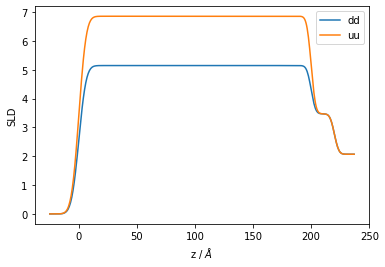

In [9]:
plt.plot(*s_dd.sld_profile(), label='dd')
plt.plot(*s_uu.sld_profile(), label="uu")
plt.ylabel("SLD")
plt.xlabel("z / $\AA$")
plt.legend();

In [10]:
# now place the Structures into a ReflectModel. ReflectModel applies resolution smearing, etc.

model_dd = ReflectModel(s_dd)
model_uu = ReflectModel(s_uu)

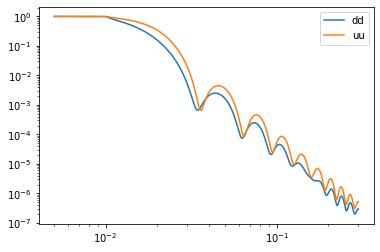

In [11]:
q = np.geomspace(0.005, 0.3, 1001)

plt.plot(q, model_dd(q), label="dd")
plt.plot(q, model_uu(q), label="uu")
plt.yscale('log')
plt.xscale('log')
plt.legend();

In [12]:
objective_dd = Objective(model_dd, data_dd, 
                         auxiliary_params=(nuclear_Fe, mag_moment_Fe, angle))
objective_uu = Objective(model_dd, data_dd, 
                         auxiliary_params=(nuclear_Fe, mag_moment_Fe, angle))

global_objective = GlobalObjective([objective_dd, objective_uu])

In [13]:
fitter = CurveFitter(global_objective)

ValueError: No parameters are being fitted